In [1]:
import torch
import torchvision
import os, time, tqdm
from models.cvae import loss, cVAE
from utils import EarlyStop
from datasets import celeba
from matplotlib import pyplot as plt
from datasets.inpainting import DeleteRandomRectangle

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def crop(x, low, high):
    x[x <= low] = low
    x[x >= high] = high
    return x

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: crop(x, 0., 1.)),
    torchvision.transforms.Resize((109, 89), antialias=True),  # (3, 218, 178) -> (3, 109, 89)
    torchvision.transforms.CenterCrop((64, 64)),
])

train_data = celeba.CelebA(root='/home/rjurisic/Desktop/FER/DUBUCE', download=False, transform=transform)

In [4]:
generator = cvae = cVAE((3, 64, 64), 2, nhid=100, ncond=16)
checkpoint = torch.load("./models/generator_fineTuned_goated.pt", map_location=device)
generator.load_state_dict(checkpoint["net"])
generator.to(device)
generator.eval()

delete_rectangle = DeleteRandomRectangle()

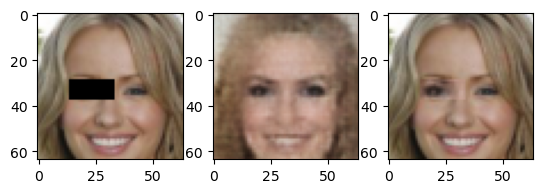

In [11]:
img, _ = train_data[53]

cropped, mask = delete_rectangle(img.unsqueeze(0))
plt.subplot(1, 3, 1)
plt.imshow(cropped.squeeze().permute(1,2,0))

generated, _, _ = generator(cropped.to(device), torch.tensor([1], device=device))
generated = generated.cpu().detach()
plt.subplot(1, 3, 2)
plt.imshow(generated.squeeze().permute(1,2,0))

result = img * (1 - mask) + generated * mask
plt.subplot(1, 3, 3)
plt.imshow(result.cpu().detach().squeeze().permute(1,2,0))

plt.show()